## Part 1

In [335]:
import numpy as np
import pandas as pd

In [336]:
data = pd.read_csv("data/Coding2_Data.csv")

var_names = data.columns
y = data[['Y']].to_numpy()
X = data.drop(['Y'], axis = 1).to_numpy()
print(X.shape, y.shape)

(506, 13) (506, 1)


In [337]:
def one_var_lasso(v, z, penalty):
    n = v.shape[0]
    z_norm = z.T @ z
    a = (v.T @ z) / z_norm

    ita = (penalty * n) / z_norm

    if a > ita:
        return a - ita
    elif a < -ita:
        return a + ita
    else:
        return 0

In [344]:
def MyLasso(X, y, lam_seq, maxit = 100):
    # Input
    # X: n-by-p design matrix without the intercept 
    # y: n-by-1 response vector 
    # lam.seq: sequence of lambda values (arranged from large to small)
    # maxit: number of updates for each lambda 
    
    # Output
    # B: a (p+1)-by-len(lam.seq) coefficient matrix 
    #    with the first row being the intercept sequence 
    n, p = X.shape
    nlam = len(lam_seq)
    B = np.zeros((p+1, nlam))
    
    ##############################
    # YOUR CODE: 
    # (1) newX = Standardizad X; 
    # (2) Record the centers and scales used in (1) 
    ##############################
    newX = np.copy(X)
    means = np.zeros(M)
    sd = np.zeros(M)
    
    for j in range(M):
        means[j] = np.mean(newX[:, j])
        # sd[j] = np.sum(np.power(newX[:, j] - means[j], 2)) / (n - 1)
        sd[j] = np.std(newX[:, j])
        newX[:, j] = (newX[:, j] - means[j]) / sd[j]
    y_mean = np.mean(y)

    # Initilize coef vector b and residual vector r
    b = np.zeros(p)
    r = y

    # Triple nested loop
    for m in range(nlam):
        b = np.zeros(p)
        r = y
        for step in range(maxit):
            for j in range(p):
                X_j = newX[:, j].reshape(-1,1)
                r = r + X_j * b[j]
                b[j] = one_var_lasso(r, X_j, lam_seq[m])
                r = r - X_j * b[j]
        B[1:, m] = b 

    ##############################
    # YOUR CODE:
    # Scale back the coefficients;
    # Update the intercepts stored in B[, 0]
    ##############################
    for m in range(nlam):
        B[0, m] = y_mean 
        B[1:, m] *= sd
    
    return(B)

In [345]:
log_lam_seq = np.linspace(-1, -8, num = 80)
lam_seq = np.exp(log_lam_seq)
myout = MyLasso(X, y, lam_seq, maxit = 1)

In [346]:
newX = np.copy(X)
means = np.zeros(M)
sd = np.zeros(M)
y_mean = np.mean(y)
for j in range(M):
    means[j] = np.mean(newX[:, j])
    # sd[j] = np.sum(np.power(newX[:, j] - means[j], 2)) / (n - 1)
    sd[j] = np.std(newX[:, j]) * (n / (n-1))
    newX[:, j] = (newX[:, j] - means[j]) / sd[j]

In [333]:
print(y_mean, 

3.0345128744146557

In [351]:
lasso_coef = pd.read_csv("data/Coding2_lasso_coefs.csv").to_numpy()

print(myout[:, 0])
print(abs(myout - lasso_coef).max())
print(y_mean, y_mean - lasso_coef[0, 79])
for m in range(len(lam_seq)):
    print(m, lasso_coef[0, m], lam_seq[m], log_lam_seq[m])
# for m in range(len(lam_seq)):
#     if abs(myout[:, m] - lasso_coef[:, m]).max() > 0.01:
#         print(m)
#         print(myout[:, m])
#         print(lasso_coef[:, m])

[3.03451287 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
1.1199735339509642
3.0345128744146557 -1.1199735339509642
0 3.03451287441466 0.36787944117144233 -1.0
1 3.03526058236585 0.33668496933316 -1.0886075949367089
2 3.13419905569265 0.30813564414990885 -1.1772151898734178
3 3.22474800496753 0.28200716944309373 -1.2658227848101267
4 3.30761882295259 0.25809426831066373 -1.3544303797468356
5 3.38346257960032 0.2362090703805977 -1.4430379746835444
6 3.45287513714836 0.21617963581782068 -1.5316455696202531
7 3.51640183147785 0.19784860448849337 -1.620253164556962
8 3.5745417565143 0.1810719596689109 -1.7088607594936709
9 3.62775168533119 0.1657178965861574 -1.7974683544303798
10 3.67644965876207 0.15166578690126978 -1.8860759493670887
11 3.72101826971503 0.1388052309994309 -1.9746835443037973
12 3.76180766899251 0.12703519064156232 -2.0632911392405062
13 3.79913831623153 0.11626319516304286 -2.15189873417

## Part 2

In [407]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as lm
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from collections import defaultdict

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [353]:
class PCR(object):

    def __init__(self, num_folds=10):
        self.folds = num_folds

    def fit(self, X, Y):
        n, p = X.shape
        indices = np.arange(n)
        np.random.shuffle(indices)
        index_sets = np.array_split(indices, self.folds)
        ncomp = min(p, n - 1 - max([len(i) for i in index_sets]))
        cv_err = np.zeros(ncomp)

        for ifold in range(self.folds):
            train_inds =  np.delete(index_sets, obj=ifold, axis=0).ravel()
            test_inds = index_sets[ifold]

            X_train = X[train_inds, :]
            pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA())])
            pipeline.fit(X_train)
            X_train = pipeline.transform(X_train)
            coefs = Y[train_inds].T @ X_train / np.sum(X_train**2, axis=0)
            b0 = np.mean(Y[train_inds])

            X_test = pipeline.transform(X[test_inds, :])

            for k in np.arange(ncomp):
                preds = X_test[:, :k] @ coefs.T[:k] + b0
                cv_err[k] += cv_err[k] + np.sum((Y[test_inds]-preds)**2)

        min_ind = np.argmin(cv_err)
        self.ncomp = min_ind+1
        pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=self.ncomp))])
        self.transform = pipeline.fit(X)
        self.model = lm().fit(self.transform.transform(X), Y)

    def predict(self, X):
        X_ = self.transform.transform(X)
        return self.model.predict(X_)

In [360]:
def lasso_cv(X_train, Y_train):
    lasso_alphas = np.logspace(-10, 1, 100)
    lassocv = LassoCV(alphas = lasso_alphas, cv = 10)
    lassocv.fit(X_train, Y_train)

    mean_mse = np.mean(lassocv.mse_path_, axis=1)
    std_mse = np.std(lassocv.mse_path_, axis=1) / np.sqrt(10) 
    
    cv_alphas = lassocv.alphas_
    min_idx = np.argmin(mean_mse)
    
    alpha_min = cv_alphas[min_idx]
    
    threshold = mean_mse[min_idx] + std_mse[min_idx]
    alpha_1se = max(cv_alphas[np.where(mean_mse <= threshold)])
    
    return alpha_min, alpha_1se

In [361]:
def ridge_cv(X_train, Y_train):
    ridge_alphas = np.logspace(-10, 1, 100)
    ridgecv = RidgeCV(alphas = ridge_alphas, cv = 10, 
                      scoring = 'neg_mean_squared_error')
    ridgecv.fit(X_train, Y_train)
    return ridgecv.alpha_

In [405]:
def get_test_errors(X, Y, num_iters=50):
    error_data = defaultdict(list)
    
    n = len(Y)
    
    for i in range(num_iters):
        if i % 10 == 0:
            print("Currently on", i, "th iteration")
            
        indices = np.arange(0, n)
        np.random.shuffle(indices)
        test_ind = indices[:int(np.floor(0.25*n))]
        train_ind = indices[len(test_ind):]
        
        # Splitting the data into training and testing sets
        X_train = X.iloc[train_ind]
        Y_train = Y[train_ind]
        X_test = X.iloc[test_ind]
        Y_test = Y[test_ind]

        # Full/OLS model
        full = lm().fit(X_train, Y_train)
        error_data["error"].append(mean_squared_error(Y_test, full.predict(X_test)))
        error_data["model_type"].append("ols")

        # Ridge Errors
        ridge_lambda = ridge_cv(X_train, Y_train)
        ridge_model = Ridge(alpha = ridge_lambda)
        ridge_model.fit(X_train, Y_train)
        error_data["error"].append(mean_squared_error(Y_test, ridge_model.predict(X_test)))
        error_data["model_type"].append("ridge")

        # Lasso Errors
        lambda_min, lambda_1se = lasso_cv(X_train, Y_train)

        lasso_model_min = Lasso(alpha = lambda_min, max_iter=10000)
        lasso_model_min.fit(X_train, Y_train)
        error_data["error"].append(mean_squared_error(Y_test, lasso_model_min.predict(X_test)))
        error_data["model_type"].append("lasso_min")
        
        lasso_model_1se = Lasso(alpha = lambda_1se, max_iter=10000)
        lasso_model_1se.fit(X_train, Y_train)
        error_data["error"].append(mean_squared_error(Y_test, lasso_model_1se.predict(X_test)))
        error_data["model_type"].append("lasso_1se")
        
        # Lasso Refit error
        if lasso_min_errors[i] < lasso_1se_errors[i]:
            nonzero_indices = np.where(lasso_model_1se.coef_ != 0)[0]
        else:
            nonzero_indices = np.where(lasso_model_min.coef_ != 0)[0]
        lm_refit = lm()
        lm_refit.fit(X_train.iloc[:, nonzero_indices], Y_train)
        error_data["error"].append(mean_squared_error(Y_test, lm_refit.predict(X_test.iloc[:, nonzero_indices])))
        error_data["model_type"].append("lasso_refit")

        # PCR model
        pcr = PCR()
        pcr.fit(X_train.to_numpy(), Y_train.to_numpy())
        pcr_errors[i] = mean_squared_error(Y_test, pcr.predict(X_test.to_numpy()))
        error_data["error"].append(mean_squared_error(Y_test, pcr.predict(X_test.to_numpy())))
        error_data["model_type"].append("pcr")
    
    return error_data

### Case 1

In [411]:
data = pd.read_csv("data/Coding2_Data2.csv")
Y = data['Y']
X = data.drop(['Y'], axis = 1)
print(X.shape, Y.shape)

scalerX = StandardScaler()
scalerX.fit(X)
newX = pd.DataFrame(scalerX.transform(X))

y_mean = Y.mean()
y_std = Y.std()
newY = pd.Series((Y - y_mean) / y_std)

error_data1 = get_test_errors(newX, newY, num_iters=50)

(506, 91) (506,)
Currently on 0 th iteration
Currently on 10 th iteration
Currently on 20 th iteration
Currently on 30 th iteration
Currently on 40 th iteration


<Axes: xlabel='model_type', ylabel='error'>

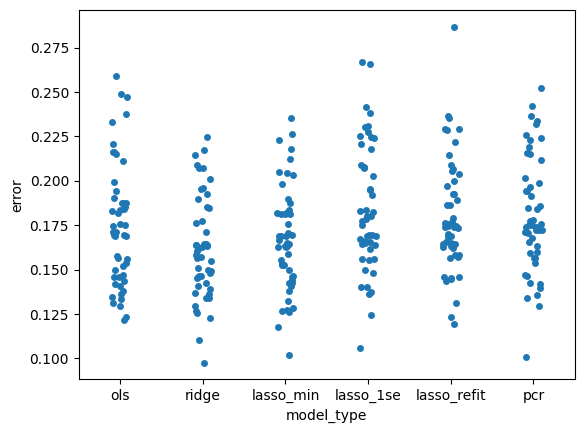

In [413]:
import seaborn as sns

sns.stripplot(data=error_data1, x="model_type", y="error")

### Case 2

In [414]:
data = pd.read_csv("data/Coding2_Data3.csv")
Y = data['Y']
X = data.drop(['Y'], axis = 1)
print(X.shape, Y.shape)

scalerX = StandardScaler()
scalerX.fit(X)
newX = pd.DataFrame(scalerX.transform(X))

y_mean = Y.mean()
y_std = Y.std()
newY = pd.Series((Y - y_mean) / y_std)

error_data2 = get_test_errors(newX, newY, num_iters=50)

(506, 591) (506,)
Currently on 0 th iteration
Currently on 10 th iteration
Currently on 20 th iteration
Currently on 30 th iteration
Currently on 40 th iteration


<Axes: xlabel='model_type', ylabel='error'>

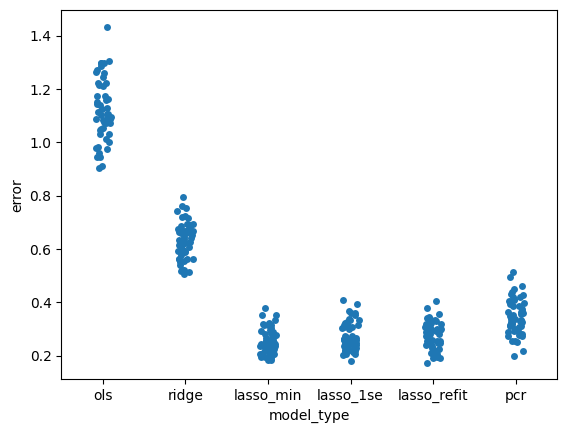

In [415]:
import seaborn as sns

sns.stripplot(data=error_data2, x="model_type", y="error")